# Global Baseline Predictors and RMSE 
The goal of this project is to predict movie ratings with top critic ratings information web scraped from Rotten Tomatoes. The predictions will first look at only raw averages across all training dataset ratings. Then, predictions will be modified to account for bias by normalizing across users and across items.


## Set-Up

The following packages will be used for math, web scraping, machine learning, visualization, and other basic functions.

In [56]:
#Basic
import pandas as pd
import numpy as np
import re

#Math
import math
from fractions import Fraction

#Webscraping
import urllib.request
from bs4 import BeautifulSoup
import json
import requests

#Machine Learning
from sklearn.model_selection import train_test_split

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Procedure
* Obtain and Clean Dataset: The dataset used will be web scraped from Rotten Tomatoes top critic reviews.

* Create User-Item Matrix: Movies that have been reviewed by at least half of the selected critics will be included in the predictions.

* Train Test Split: Split the remaining reviews between a train and test dataset, using a test size of 20% and stratifying by movie.

* Make Predictions: Make predictions for train and test reviews based on raw average and user-item bias.

* Evaluate Results: Determine the Root Mean Square Error of predictions to evaluate the accuracy of the model.

## Obtain and Clean Dataset
Rotten Tomatoes has a paginated list of movie reviews for every critic on their website. The following code chunk creates and executes a function `scrape_rotten_tomatoes` that accepts the following variables:
* `reviewer list`: a list of critics to include in the model
* `pages`: the number of pages of reviews to scrape 

For this dataset, nine top critics have been selected and the first five pages of their reviews have been scraped from Rotten Tomatoes. 

![reviews_table](https://raw.githubusercontent.com/mkivenson/Recommender-Systems/master/Global%20Baseline%20Predictors%20and%20RSME/Review_Table.png)

The function `scrape_rotten_tomatoes` includes the following steps:
* Create empty pandas dataframe to store scraped records in
* Use BeautifulSoup to web scrape json string of movie reviews for each critic and each page
* Extract relevant items from json string into a pandas dataframe
* Remove reviews with no ratings (some critics only evaluate a movie as rotten or fresh, with no numeric rating)
* Convert any letter ratings into a fractional rating (ex. A+ = 100/100)
* Convert fraction ratings to floats (most critics score movies out of 4, 5, or 10)
* Return the resulting dataframe without duplicate records (if over-pagination occurs)

In [57]:
def scrape_rotten_tomatoes(reviewer_list, pages):
    # Create empty pandas dataframe
    reviews = pd.DataFrame(columns = ['author','movie','rating','tomatometer','date','review'])
    
    # Use BeautifulSoup to web scrape json string of movie reviews for each reviewer page
    for x in reviewer_list:
        page_range = range(1,pages+1) # Pagination
        for i in page_range:
            URL = "https://www.rottentomatoes.com/critic/" + x + "/movies?page=" + str(i) 
            page = urllib.request.urlopen(URL)
            soup = BeautifulSoup(page)
            json_tag = soup.select('head script[type="application/ld+json"]')[0]
            json_string = json_tag.string
            json_string = json.loads(str(json_string))

            # Pull relevant items from json string into a pandas dataframe
            for thing in json_string['@graph'][1]['itemListElement']:
                reviews = reviews.append({
                    'author': thing['item']['author']['name'],
                    'movie': thing['item']['itemReviewed']['name'],
                    'rating': thing['item']['reviewRating']['ratingValue'],
                    'tomatometer': thing['item']['reviewRating']['tomatometer'],
                    'date': thing['item']['datePublished'],
                    'review': thing['item']['reviewBody']
                }, ignore_index = True)
                
    # Remove reviews with empty ratings
    reviews = reviews[pd.notnull(reviews.rating)]
    
    # Convert any letter grades to fraction grades (rare scenario)
    def letter_to_frac(x):
        x = x.replace(r'A+',"100/100")
        x = x.replace(r'A-',"90/100")
        x = x.replace(r'A',"95/100")
        x = x.replace(r'B+',"85/100")
        x = x.replace(r'B-',"75/100")
        x = x.replace(r'B',"80/100")
        x = x.replace(r'C+',"65/100")
        x = x.replace(r'C-',"55/100")
        x = x.replace(r'C',"60/100")
        x = x.replace(r'D+',"45/100")
        x = x.replace(r'D-',"35/100")
        x = x.replace(r'D',"40/100")
        x = x.replace(r'F',"20/100")
        return x
    reviews.loc[:, 'rating'] = letter_to_frac(reviews.rating)
    
    # Convert fraction grades to floats
    reviews["rating"] = reviews["rating"].apply(lambda x: float(float(x.split( '/' )[0]) / float(x.split( '/' )[1])))
    
    # Return the resulting clean dataframe without duplicates (caused if there is excessive pagination)
    return reviews.drop_duplicates()

# Define a list of reviewers using format "firstname-lastname"
reviewer_list = ["christy-lemire",
           "pete-hammond",
           "matthew-lickona",
           "rafer-guzman",
           "peter-howell",
           "richard-roeper",
           "ty-burr",
           "james-berardinelli",
           "katie-walsh"]

# Provide the amount of pages to iterate through
pages = 5

# Run the web-scraping and clean-up function and assign to the dataframe 'reviews'
reviews = scrape_rotten_tomatoes(reviewer_list, pages)
reviews.head()

,author,movie,rating,tomatometer,date,review
0,Christy Lemire,The Secret Life of Pets 2,0.500,rotten,"Jun 6, 2019","Your kids will be sufficiently entertained, bu..."
1,Christy Lemire,Rocketman,0.625,fresh,"May 28, 2019",Egerton gives a performance with such thrills ...
2,Christy Lemire,Running with Beto,0.750,fresh,"May 28, 2019","Running With Beto is an intimate, thorough loo..."
3,Christy Lemire,The Sun Is Also a Star,0.625,fresh,"May 16, 2019",The leads are so lovely and the city is so shi...
4,Christy Lemire,The Hustle,0.500,rotten,"May 10, 2019","It's not terrible. It's not anything, really, ..."


## Create User-Item Matrix
### Filter Results
To create a more condensed ratings model, only include movies that at least half of the selected critics have reviewed.

In [58]:
#Filter reviews to only show movies that at least half of reviewers have watched
movie_counts = reviews.groupby(by='movie').size()
movie_counts = pd.DataFrame(movie_counts).reset_index()
movie_counts.columns = ["movie","count_reviews"]
movie_list = list(movie_counts[movie_counts.count_reviews >= math.ceil(len(reviewer_list)/2)].movie)
print("There are " + str(len(movie_list)) + " movies that at least half of reviewers have watched.")

There are 125 movies that at least half of reviewers have watched.


### Matrix Creation
The following code chunk creates the user-item matrix for critic-movie ratings. Movies that have not been reviewed by a certain critic have values of "NaN" in the matrix.

In [59]:
#Take filtered reviews and transform into a user-item matrix
reviews = reviews[reviews.movie.isin(movie_list)][["author","movie","rating"]]

reviews_matrix = reviews.pivot_table(index = "movie", columns = "author", values = "rating")
reviews_matrix

author,Christy Lemire,James Berardinelli,Katie Walsh,Matthew Lickona,Pete Hammond,Peter Howell,Rafer Guzman,Richard Roeper,Ty Burr
movie,,,,,,,,,
A Private War,NaN,NaN,0.875,0.2,0.8,NaN,0.750,0.750,0.750
A Quiet Place,NaN,0.875,NaN,NaN,1.0,0.750,NaN,0.750,0.750
A Simple Favor,NaN,0.625,0.750,0.2,0.5,NaN,NaN,0.875,NaN
A Star Is Born,NaN,0.750,1.000,0.2,1.0,1.000,0.750,1.000,0.875
A Wrinkle in Time,NaN,NaN,0.625,NaN,0.5,NaN,0.500,0.500,0.625
Aladdin,NaN,0.500,0.750,0.2,NaN,NaN,0.375,0.750,0.625
Alita: Battle Angel,NaN,0.625,0.500,NaN,0.6,0.500,0.625,0.375,NaN
American Made,NaN,NaN,NaN,0.4,0.9,0.750,0.750,NaN,0.750
Ant-Man and the Wasp,0.750,0.500,0.750,0.2,0.7,0.750,0.625,0.750,0.875


### Visualize Reviews
To preview potential bias in the recommender system, a rating overview by critic can be created. We see from the box plots below that Matthew Lickona is a particularly harsh critic. If a different list of critics is passed into the `scrape_rotten_tomatoes` function, the box plot will show different results.

Text(0.5, 1.0, 'Rating Overview by Reviewer')

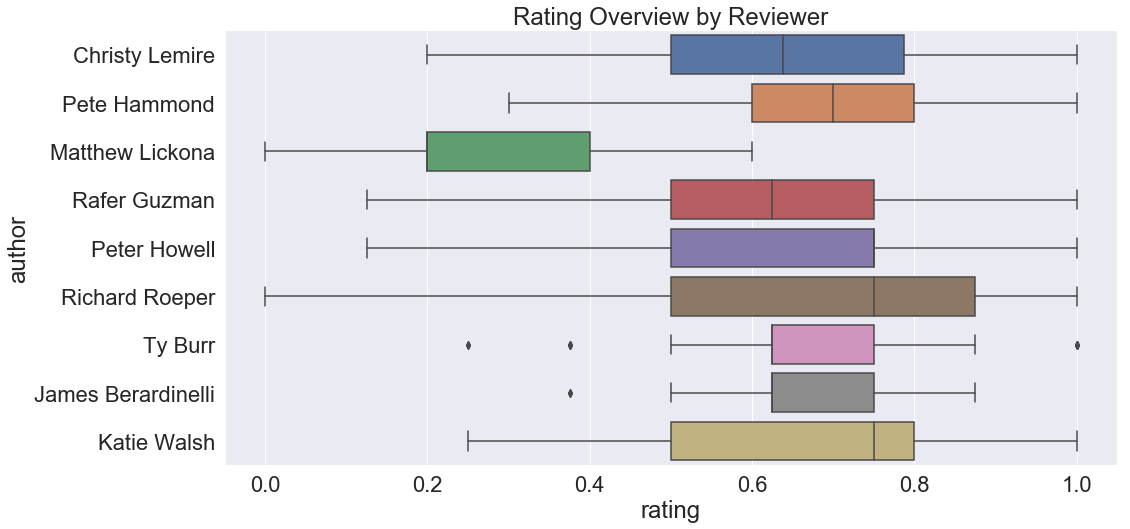

In [60]:
plt.figure(figsize=(16, 8))
sns.set_style("darkgrid")
sns.set(font_scale = 2)
sns.boxplot(x = "rating", y = "author", data = reviews).set_title('Rating Overview by Reviewer')

## Train Test Split
To begin creating movie rating predictions for each critic, the reviews data is split between a test set and a train set. The test size will be 20% of the total reviews, and the split between train and test sets by stratifying by movie.

In [61]:
X = reviews[["author","movie","rating"]]
y = reviews["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify = X["movie"], 
                                                    random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(616, 3) (616,)
(155, 3) (155,)


## Make Predictions and Evaluate Results
### Raw Average Rating
The next step is to calculate the raw average (mean) rating for every critic-movie combination.

In [62]:
train_mean = round(y_train.mean(),2)
print("The mean rating for all reviewers/all movies in the train set is " + str(train_mean) + ".")

The mean rating for all reviewers/all movies in the train set is 0.63.


### Root Mean Square Error for Raw Average
The RMSE for using raw average as the predictor for both the training data and the test data is calculated below.

In [63]:
MSE_train = 0
for x in y_train:
    MSE_train = MSE_train + ((train_mean - x) ** 2)
RMSE_train = round(math.sqrt(MSE_train / len(y_train)),5)
print("The RMSE using the raw average as the predicted value for train data is " + str(RMSE_train) + ".")

MSE_test = 0
for x in y_test:
    MSE_test = MSE_test + ((train_mean - x) ** 2)
RMSE_test = round(math.sqrt(MSE_test / len(y_test)),5)
print("The RMSE using the raw average as the predicted value for test data is " + str(RMSE_test) + ".")

The RMSE using the raw average as the predicted value for train data is 0.218.
The RMSE using the raw average as the predicted value for test data is 0.21502.


### Bias Calculations
To make the predictions more accurate, we take into account movie and critic bias. We saw from the visualization earlier that some critics are harsher than others. Similarly, some movies are of better quality than others. By taking critic harshness and movie quality into account, we can make these biases reflected in the predictions.

In [64]:
author_bias = X_train.groupby(by="author").agg("mean").reset_index()
author_bias = author_bias.assign(author_bias = lambda author_bias: author_bias.rating - train_mean)
movie_bias = X_train.groupby(by="movie").agg("mean").reset_index()
movie_bias = movie_bias.assign(movie_bias = lambda movie_bias: movie_bias.rating - train_mean)

In [65]:
#Add author_bias and movie_bias to the train set
X_train_bias = pd.merge(X_train, author_bias[["author","author_bias"]], how = 'left', on = "author")
X_train_bias = pd.merge(X_train_bias, movie_bias[["movie","movie_bias"]], how = 'left', on = "movie")
X_train_bias = X_train_bias[["author","movie","rating","author_bias","movie_bias"]]

#Add baseline predictor to the train set
X_train_bias = X_train_bias.assign(
    predictor = lambda X_train_bias: (train_mean + X_train_bias.author_bias + X_train_bias.movie_bias))
X_train_bias.predictor = X_train_bias.predictor.apply(lambda x: max(min(x,1),0))

#Add author_bias and movie_bias to the test set
X_test_bias = pd.merge(X_test, author_bias[["author","author_bias"]], how = 'left', on = "author")
X_test_bias = pd.merge(X_test_bias, movie_bias[["movie","movie_bias"]], how = 'left', on = "movie")
X_test_bias = X_test_bias[["author","movie","rating","author_bias","movie_bias"]]

#Add baseline predictor to the test set
X_test_bias = X_test_bias.assign(
    predictor = lambda X_test_bias: (train_mean + X_test_bias.author_bias + X_test_bias.movie_bias))
X_test_bias.predictor = X_test_bias.predictor.apply(lambda x: max(min(x,1),0))

### RMSE for Baseline Predictors
After taking bias into account in the baseline predictions, we see the RMSE calculations for both train and test data decrease.

In [66]:
MSE_train_bias = 0
for i in range(len(X_train_bias.predictor)):
    MSE_train_bias = MSE_train_bias + ((X_train_bias.rating[i] - X_train_bias.predictor[i]) ** 2)
RMSE_train_bias = round(math.sqrt(MSE_train_bias / len(X_train_bias)),5)
print("The RMSE using bias in the predicted value calculations for train data is " + str(RMSE_train_bias) + ".")

The RMSE using bias in the predicted value calculations for train data is 0.1256.


In [67]:
MSE_test_bias = 0
for i in range(len(X_test_bias.predictor)):
    MSE_test_bias = MSE_test_bias + ((X_test_bias.rating[i] - X_test_bias.predictor[i]) ** 2)
RMSE_test_bias = round(math.sqrt(MSE_test_bias / len(X_test_bias)),5)
print("The RMSE using bias in the predicted value calculations for test data is " + str(RMSE_test_bias) + ".")

The RMSE using bias in the predicted value calculations for test data is 0.14061.


## Summary
The prediction accuracy results are summarized below. It is evident that taking bias into account will improve prediction accuracy.

In [68]:
print("The RMSE for the raw mean predictor for the train set is " + str(RMSE_train))
print("The RMSE for the raw mean predictor for the test set is " + str(RMSE_test))
print("The RMSE for the raw mean with bias predictor for the train set is " + str(RMSE_train_bias))
print("The RMSE for the raw mean with bias predictor for the test set is " + str(RMSE_test_bias))

The RMSE for the raw mean predictor for the train set is 0.218
The RMSE for the raw mean predictor for the test set is 0.21502
The RMSE for the raw mean with bias predictor for the train set is 0.1256
The RMSE for the raw mean with bias predictor for the test set is 0.14061


### Actual Ratings vs Predictions
It is also helpful to visualize a comparison of the predicted and actual ratings for the train and test sets. From the plots below, we see that the predicted and actual reviews are strongly correlated.

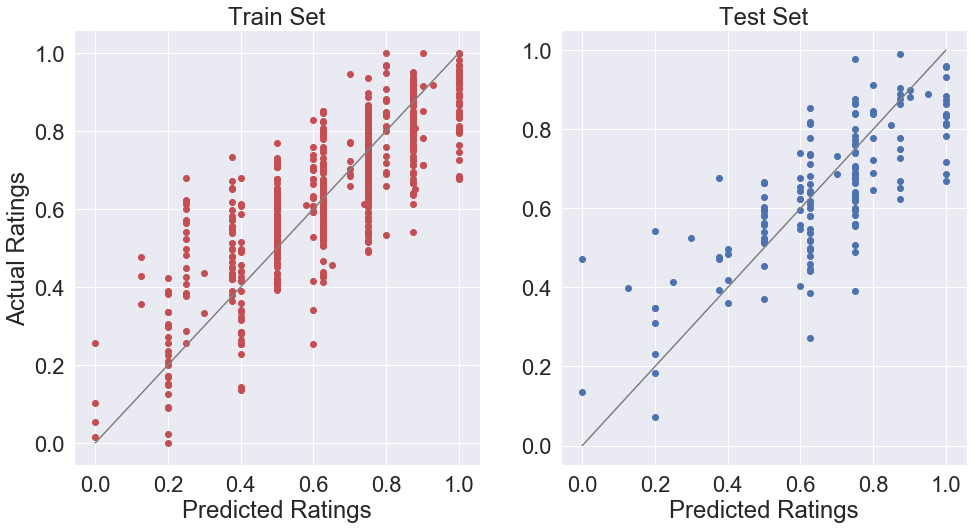

In [71]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X_train_bias["rating"], X_train_bias["predictor"], color='r')
x = np.arange(0,1.1,.1)
plt.plot(x, x + 0, linestyle='solid', color="gray")
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('Train Set')


plt.subplot(1, 2, 2)
plt.scatter(X_test_bias["rating"], X_test_bias["predictor"], color='b')
plt.plot(x, x + 0, linestyle='solid', color="gray")
plt.xlabel('Predicted Ratings')
plt.title('Test Set')
plt.show()

### Residuals
Looking at the residuals created by the difference between actual and predicted values is also an insightful visualization. For both the train and test sets, the residuals are symmetrically distributed and are mostly clustered around 0. 

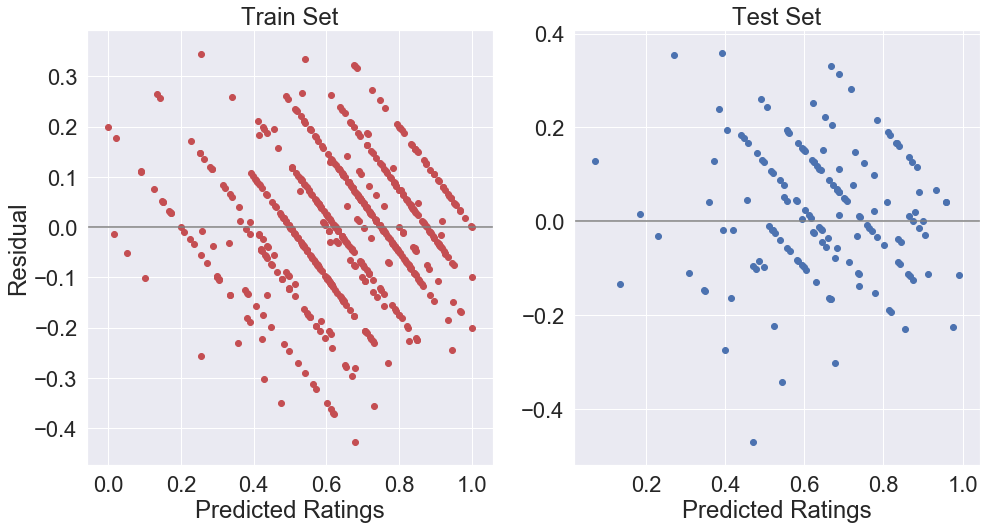

In [72]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X_train_bias["predictor"],X_train_bias["rating"] - X_train_bias["predictor"], color='r')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residual')
plt.axhline(y=0, color='gray')
plt.title('Train Set')

plt.subplot(1, 2, 2)
plt.scatter(X_test_bias["predictor"],X_test_bias["rating"] - X_test_bias["predictor"], color='b')
plt.xlabel('Predicted Ratings')
plt.title('Test Set')
plt.axhline(y=0, color='gray')
plt.show()

## Next Steps
* Allow user input for `reviewer list` and `pages`
* Web scrape full list of reviewer names and information from Rotten Tomatoes
* Cluster reviewer by preference for collaborative filtering
* Attempt more advanced methods of determining user-item bias
* Create interactive notebook widget to allow for custom movie recommendations